# load all the modules 

In [87]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# 1- Data preparation

## Loading Data

In [88]:
# read the datafile
df_initial = pd.read_csv('Input/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceNo': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [89]:
# Convert InvoiceDate to datetime

df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [90]:
df_initial.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Exploring And Cleaning

In [91]:
# gives some infos on columns types and numer of null values
def infos_on_columns(df_initial):
    tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
    tab_info=pd.concat([tab_info,pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'})],axis=0)
    tab_info=pd.concat([tab_info,pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                             rename(index={0:'null values (%)'})],axis=0)
    return tab_info
tab_info = infos_on_columns(df_initial)  
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


In [92]:
# show first lines

display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


While looking at the number of null values in the dataframe, it is interesting to note that ∼25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless. So I delete them from the dataframe

In [93]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (406829, 8)


In [94]:
# changing CustomerID data type to int

df_initial['CustomerID'] = df_initial['CustomerID'].astype(int)

In [95]:
# gives some infos on columns types and numer of null values
tab_info = infos_on_columns(df_initial)
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,int32,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (406829, 8)


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them

In [97]:
print(f'Duplicated Entries: {df_initial.duplicated().sum()}')
df_initial.drop_duplicates(inplace = True)

Duplicated Entries: 5225


# 2- Exploring the content of variables

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation.<br>
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
**Description:** Product (item) name. Nominal.<br>
**Quantity:** The quantities of each product (item) per transaction. Numeric.<br>
**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.<br>
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.<br>
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
**Country:** Country name. Nominal, the name of the country where each customer resides.<br>

## 2.1 Countries

In [98]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print(f'No. of Countries in the Dataframe: {len(countries)}')

No. of Countries in the Dataframe: 37


In [99]:
#show the result on a chloropleth map:

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

In [100]:
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}),width=800, height=800)

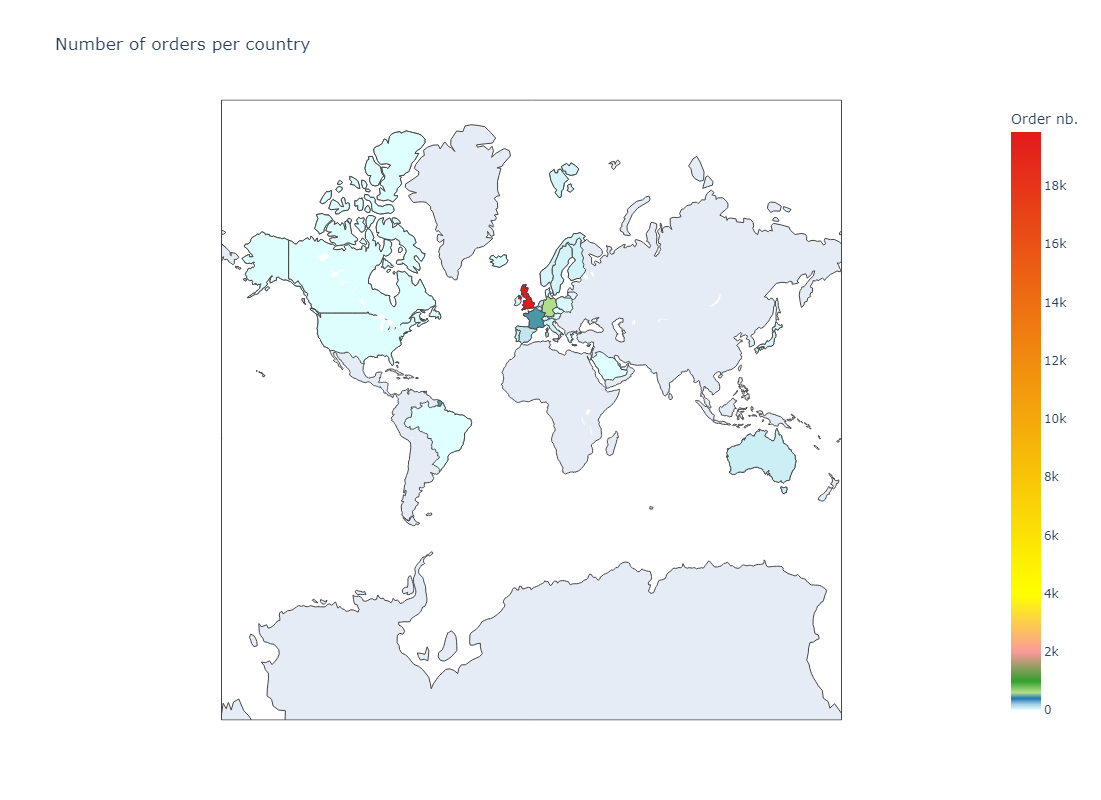

In [101]:
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

We see that the dataset is largely dominated by orders made from the UK.

## 2.2 Customers and products

The dataframe contains ∼400,000 entries. What are the number of users and products in these entries ?

In [102]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of ∼22'000.

Now I will determine the number of products purchased in every transaction:

In [103]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Quantity
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:

the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled<br>
the existence of users who only came once and only purchased one product (e.g. nº12346)<br>
the existence of frequent users that buy a large number of items at each order<br>

## 2.2.1 Cancelling orders

First of all, I count the number of transactions corresponding to canceled orders:

In [104]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

,CustomerID,InvoiceNo,Quantity,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [105]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large (∼16% of the total number of transactions). Now, let's look at the first lines of the dataframe:

In [106]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [107]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[3]) & (df_initial['UnitPrice'] == col[4])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:

In [108]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][['CustomerID','Quantity','StockCode',
                                                                                                 'Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[3]) & (df_initial['UnitPrice'] == col[4])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [109]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []
for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)      
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: 
                continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In the above function, I checked the two cases:

a cancel order exists without counterpart<br>
there's at least one counterpart with the exact same quantity<br>
The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [110]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Among these entries, the lines listed in the **doubtfull_entry** list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for ∼1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [111]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("num of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

num of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [112]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0


We see that the quantity canceled is greater than the sum of the previous purchases.

## 2.2.2 StockCode

Above, it has been seen that some values of the StockCode variable indicate a particular transaction (i.e. D for Discount). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [113]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [114]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

## 2.2.3 Basket Price

I create a new variable that indicates the total price of every purchase:

In [115]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [116]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

In [117]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [118]:
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prizes:

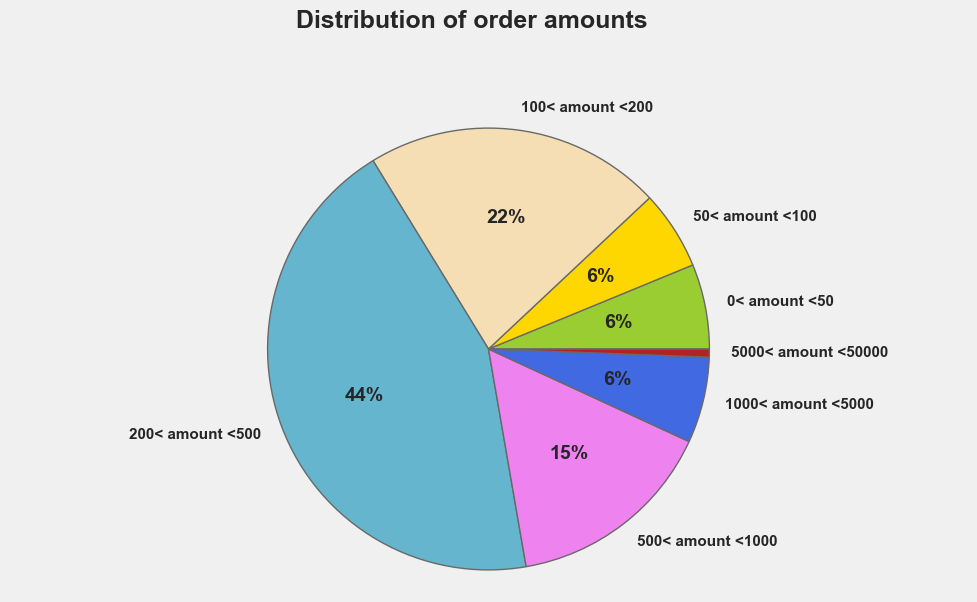

In [119]:
# Purchase countdown
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}< amount <{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that ∼65% of purchases give prizes in excess of £ 200.

# 3. Insight on product categories

In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

## 3.1 Products Description

As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

In [120]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

extract the names (proper, common) appearing in the products description
for each name, I extract the root of the word and aggregate the set of names associated with this particular root
count the number of times each root appears in the dataframe
when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)
The first step of the analysis is to retrieve the list of products:

In [121]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [122]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


The execution of this function returns three variables:

keywords: the list of extracted keywords<br>
keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots<br>
count_keywords: dictionary listing the number of times every word is used<br>
At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [123]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

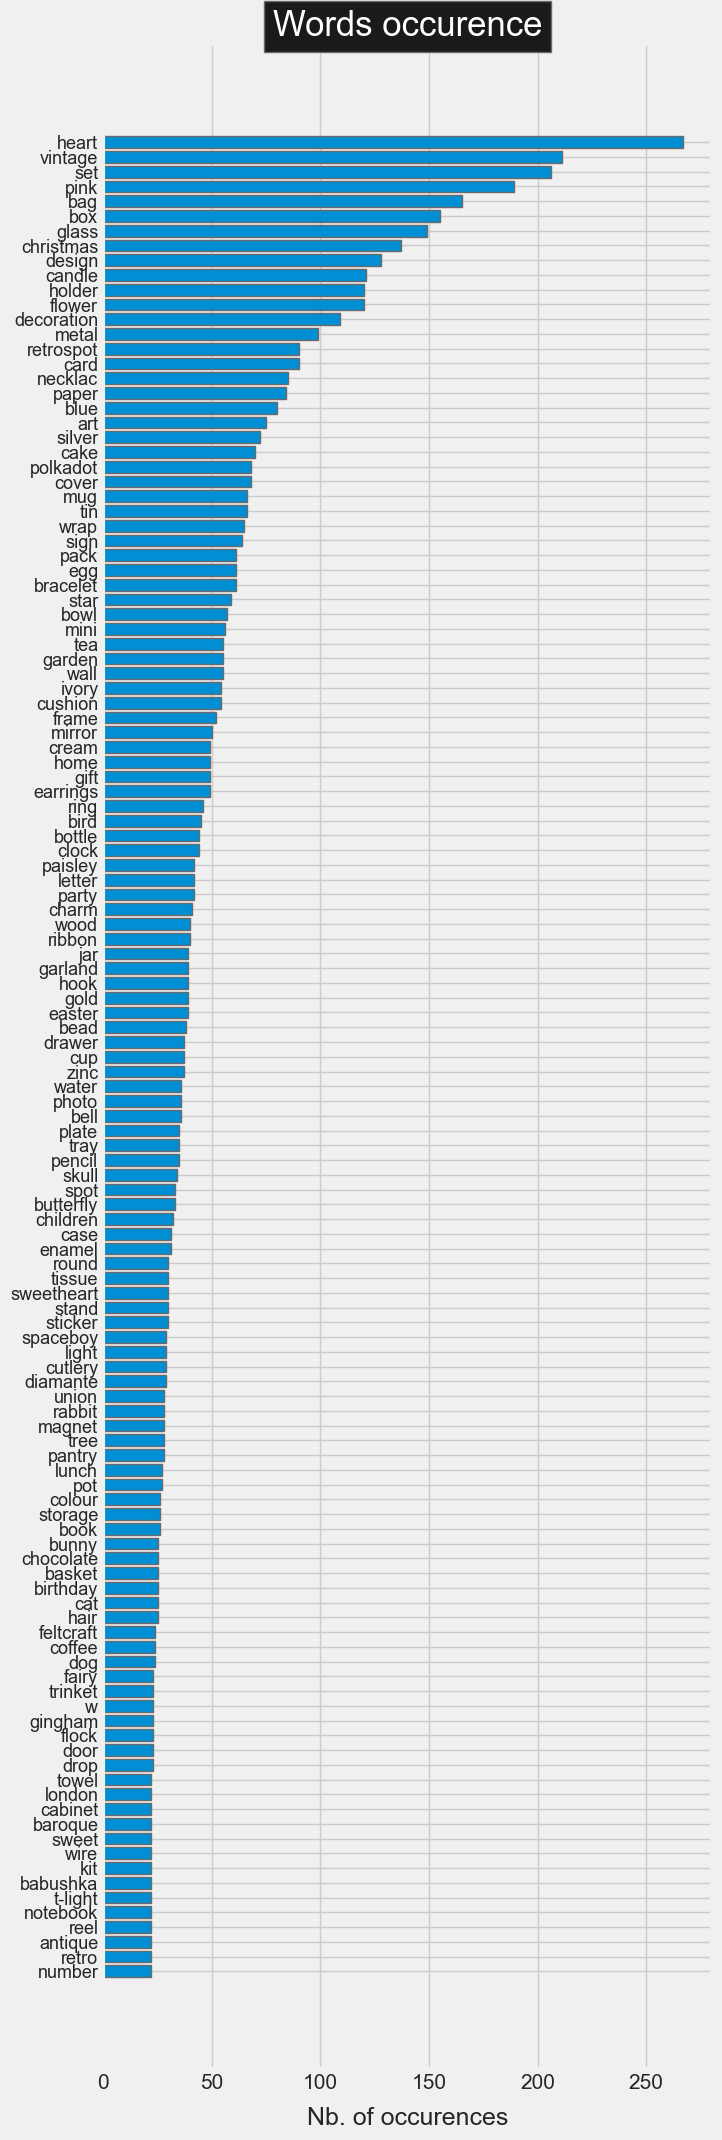

In [124]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

## 3.2 Defining product categories

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times

In [125]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 193


## 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the  X
  matrix

In [126]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [127]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


The  X
  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [128]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:


In [129]:
print("{:<8} {:<20} \n".format('gamme', 'no. products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    no. products         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


## 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that the kmeans method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the kmodes package which is not available on the current plateform. Hence, I use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [130]:
matrix = X.to_numpy()
wcss = []
random_state=42
def hamming_distance(x1, x2):
  return hamming(x1, x2)
for n_clusters in range(3,10):
    #kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans = KModes(n_clusters=n_clusters, init='Huang', n_init=30,random_state=random_state)
    #kmeans.fit(matrix)
    #clusters = kmeans.predict(matrix)
    clusters = kmeans.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    wcss.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14740815062347604
For n_clusters = 6 The average silhouette_score is : 0.14339199018066012
For n_clusters = 7 The average silhouette_score is : 0.14221848893427338
For n_clusters = 8 The average silhouette_score is : 0.13976862758068684
For n_clusters = 9 The average silhouette_score is : 0.1385801104034788


Text(0, 0.5, 'Silhouette score')

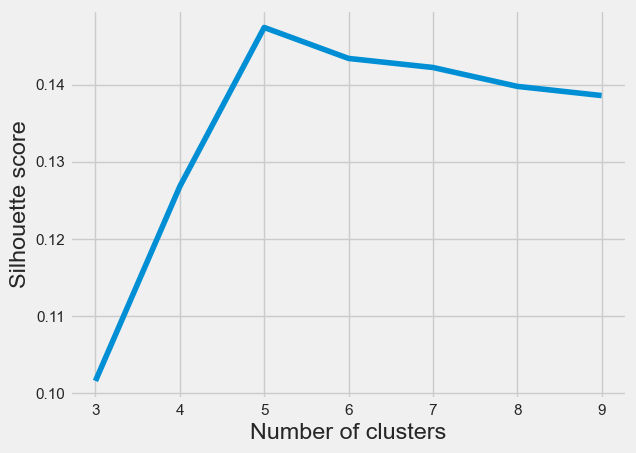

In [131]:
plt.plot(range(3,10),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.04
  will be obtained for all clusters with n_clusters  >
  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters.

In [132]:
kmeans = KModes(n_clusters=5, init='Huang', n_init=30,random_state=random_state)
clusters = kmeans.fit_predict(matrix)

## 3.2.3 Characterizing the content of clusters

I check the number of elements in every class:


In [133]:
pd.Series(clusters).value_counts()

3    1009
1     964
2     673
0     626
4     606
Name: count, dtype: int64

In [134]:
n_clusters = len(pd.Series(clusters).value_counts())

### a / Silhouette intra-cluster score

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters.

In [135]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

In [136]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

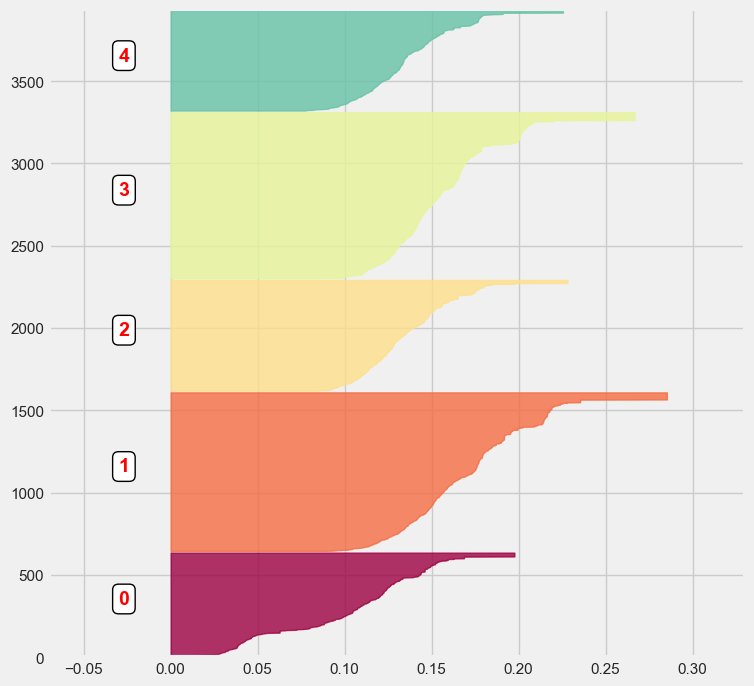

In [137]:
# and do the graph
graph_component_silhouette(len(pd.Series(clusters).value_counts()), [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [138]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

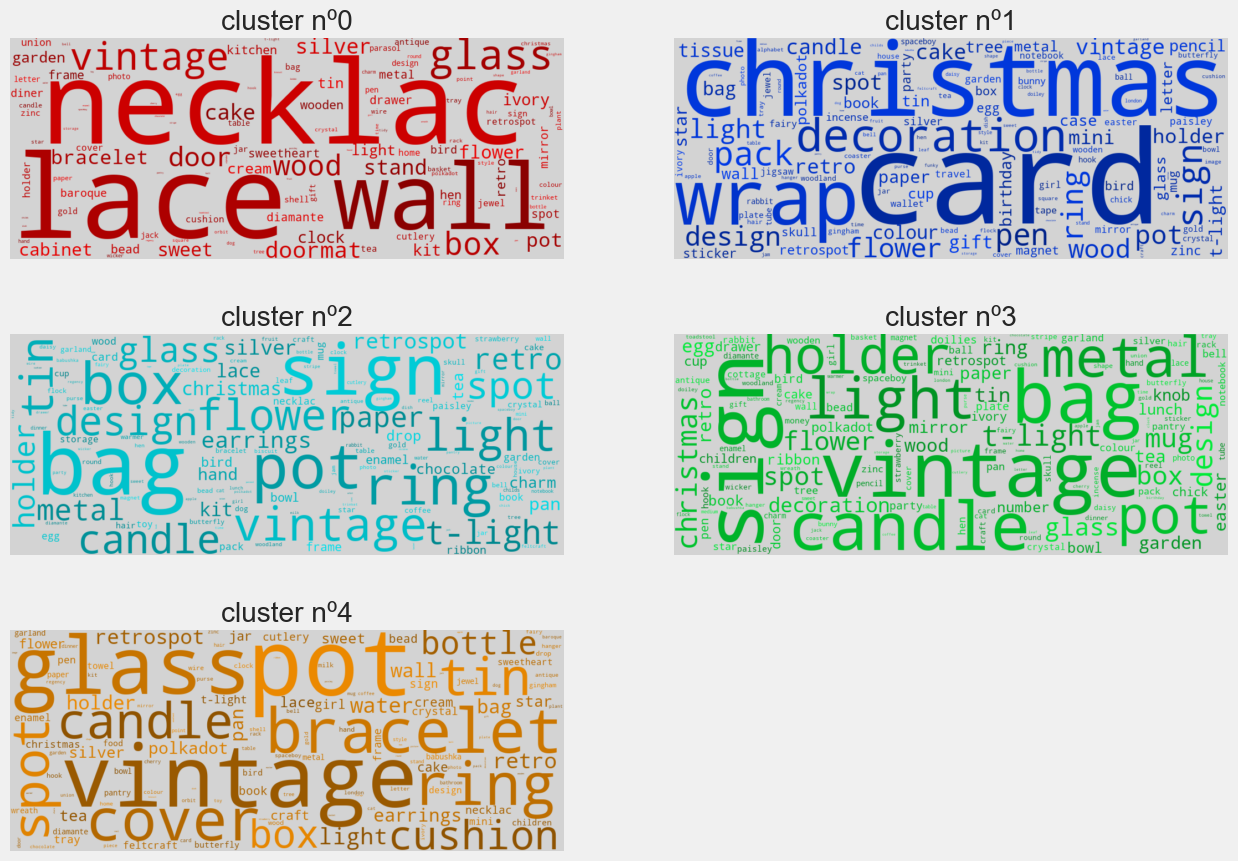

In [139]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)   

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

## c / Principal Component Analysis

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:



In [140]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

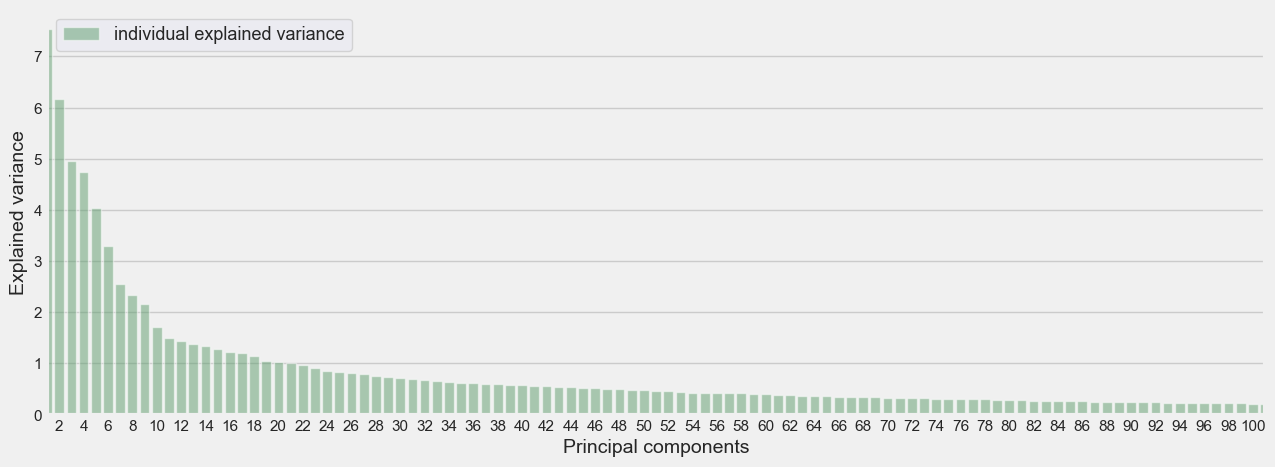

In [141]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
#plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',label='cumulative explained variance')
sns.barplot(x=np.arange(1, matrix.shape[1] + 1), y=pca.explained_variance_ratio_*100, alpha=0.5, color='g', label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data

In [142]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

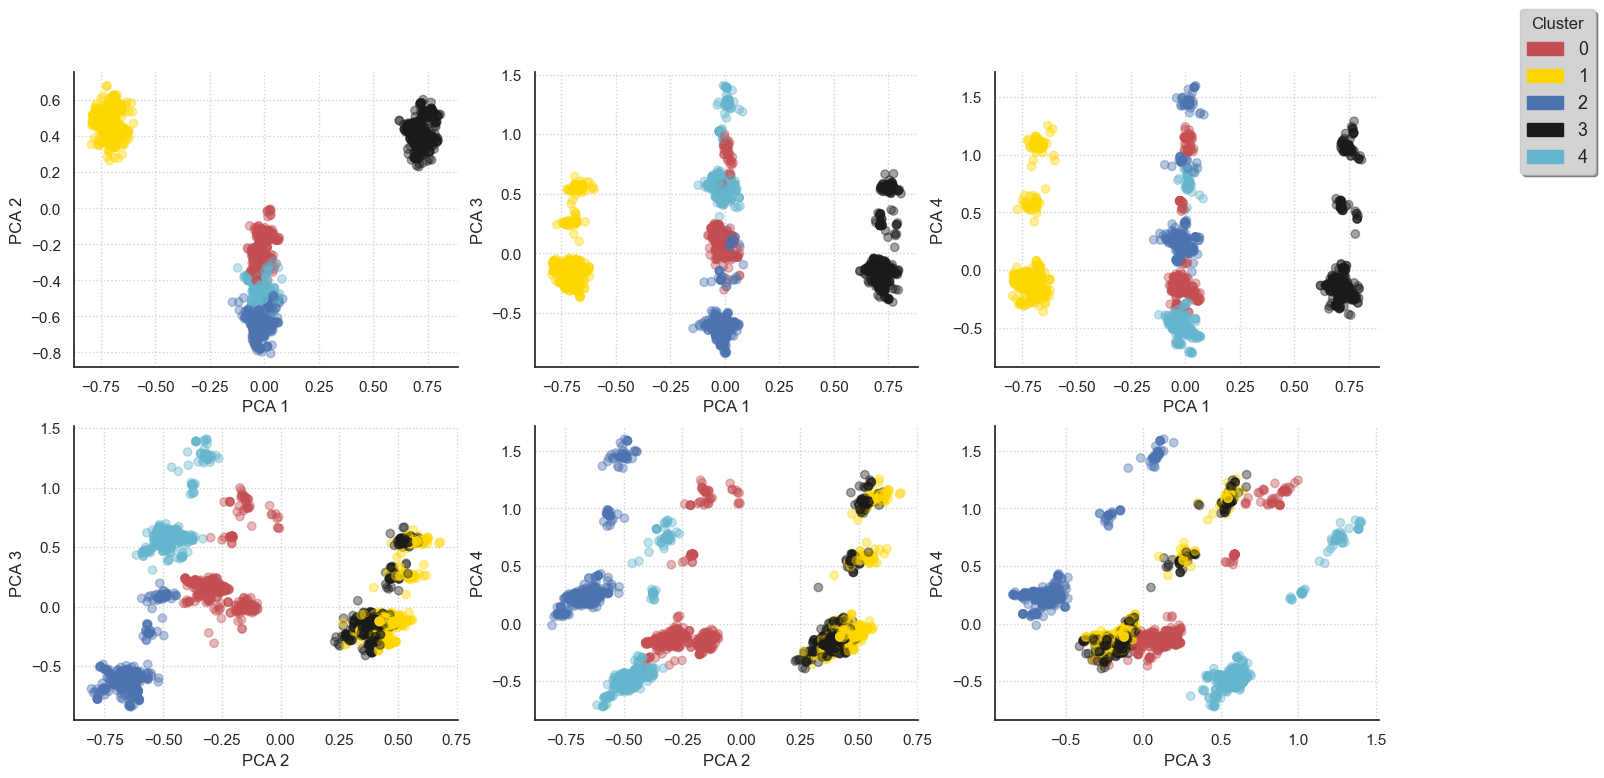

In [143]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

# 4. Customer categories

## 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluster of each product :

In [144]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

In [145]:
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

## 4.1.1 Grouping products

In a second step, I decide to create the categ_N variables (with  N∈[0:4]
 ) that contains the amount spent in each product category:

In [146]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,15.3,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put it in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [147]:
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# percentage of order price / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col] 
#_____________________
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,23.40,83.40,187.2,293.35,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,38.25,84.34,53.10,130.5,169.20,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,38.25,81.00,71.10,330.9,115.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,19.90,41.40,78.06,74.4,168.76,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,136.05,61.30,119.70,109.7,158.16,2011-08-02 08:48:00.000000000


## 4.1.2 Separation of data over time

The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [148]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [149]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.to_datetime(datetime.date(2011,10,1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.to_datetime(datetime.date(2011,10,1))]
basket_price = set_entrainement.copy(deep = True)

In [150]:
print(set_entrainement['InvoiceDate'].min(), '->',  set_entrainement['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-09-30 15:52:00


In [151]:
print(set_test['InvoiceDate'].min(), '->',  set_test['InvoiceDate'].max())

2011-10-02 10:32:00 -> 2011-12-09 12:50:00


## 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [152]:
# number of visits and stats on basket amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,12.787815,10.442659,14.524555,29.836681,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.000000,41.953217,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,11.961722,11.692584,27.900718,48.444976,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,67.534402,0.491808,3.370331,12.892120,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,67.078652,0.000000,19.887640,13.033708,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [153]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,12.787815,10.442659,14.524555,29.836681,32.408290,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.000000,41.953217,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,11.961722,11.692584,27.900718,48.444976,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,67.534402,0.491808,3.370331,12.892120,15.711338,2,226
4,12353,1,89.00,89.00,89.000000,89.00,67.078652,0.000000,19.887640,13.033708,0.000000,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [154]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("no. of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

no. of customers with a single purchase: 1445/3608  (40.05%)


## 4.2 Creation of customers categories

### 4.2.1 Data encoding

The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [155]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I create a matrix where these data are standardized:

In [156]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  23.21847344
  13.98907929  21.19884856  25.22916919  16.37327913]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [157]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

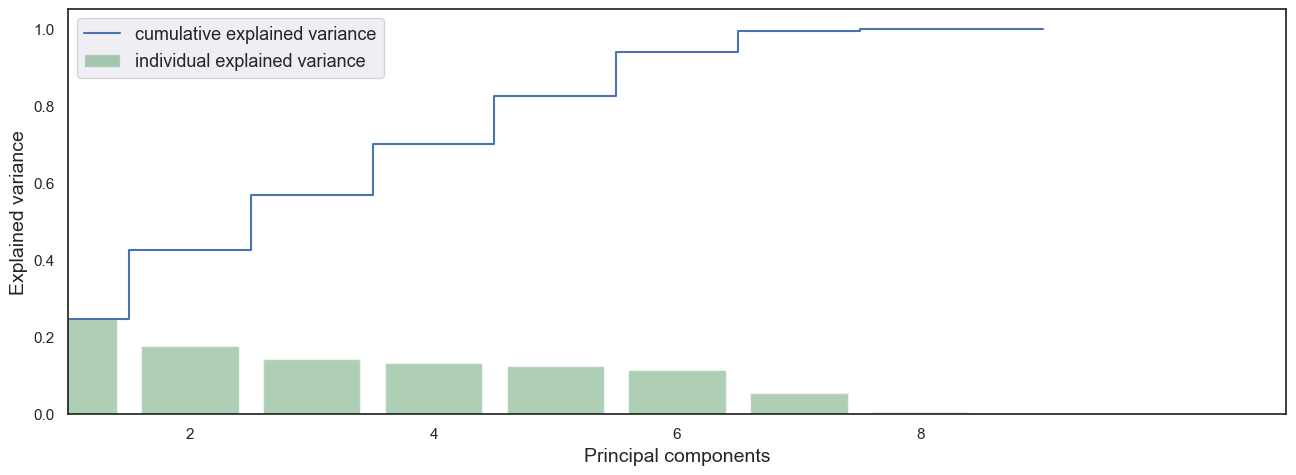

In [158]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

## 4.2.2 Creation of customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the k-means algorithm from scikit-learn. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 8 clusters:

In [159]:
n_clusters = 11
random_state=42
silhouette_score_ph=[]
wcss=[]
for n_cluster in range(3,15): 
    kmeans = KMeans(init='k-means++', n_clusters = n_cluster, n_init=100,random_state=random_state)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    silhouette_score_ph.append(silhouette_avg)
    wcss.append(kmeans.inertia_)
    print('score of silhouette: {:<.3f}'.format(silhouette_avg))

score of silhouette: 0.159
score of silhouette: 0.152
score of silhouette: 0.161
score of silhouette: 0.174
score of silhouette: 0.194
score of silhouette: 0.207
score of silhouette: 0.204
score of silhouette: 0.212
score of silhouette: 0.218
score of silhouette: 0.202
score of silhouette: 0.187
score of silhouette: 0.191


Text(0, 0.5, 'Silhouette score')

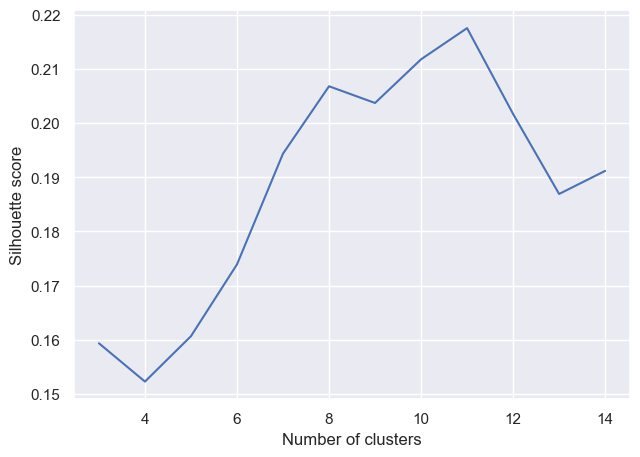

In [160]:
plt.plot(range(3,15),silhouette_score_ph)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

Text(0, 0.5, 'Elbow score')

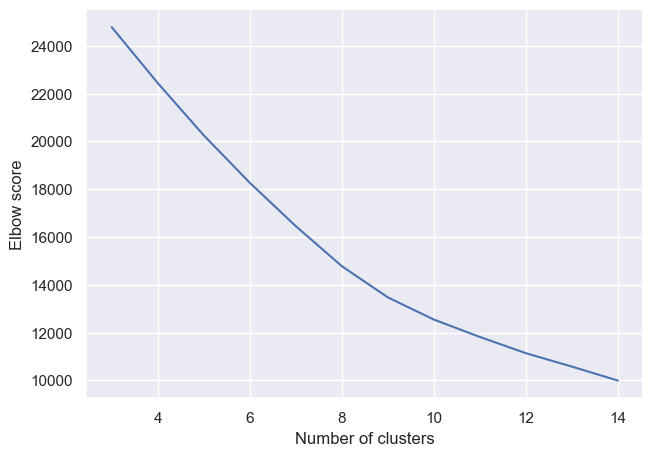

In [161]:
plt.plot(range(3,15),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Elbow score')

In [162]:
n_clusters = 8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100,random_state=random_state)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score of silhouette: {:<.3f}'.format(silhouette_avg))

score of silhouette: 0.207


At first, I look at the number of customers in each cluster:

In [163]:
pd.DataFrame(pd.Series(clusters_clients).value_counts()).rename(columns={'count':'nb. of clients'}).T

,6,0,7,2,3,1,5,4
nb. of clients,1543,691,529,443,268,104,23,7


### a / Report via the PCA

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [164]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

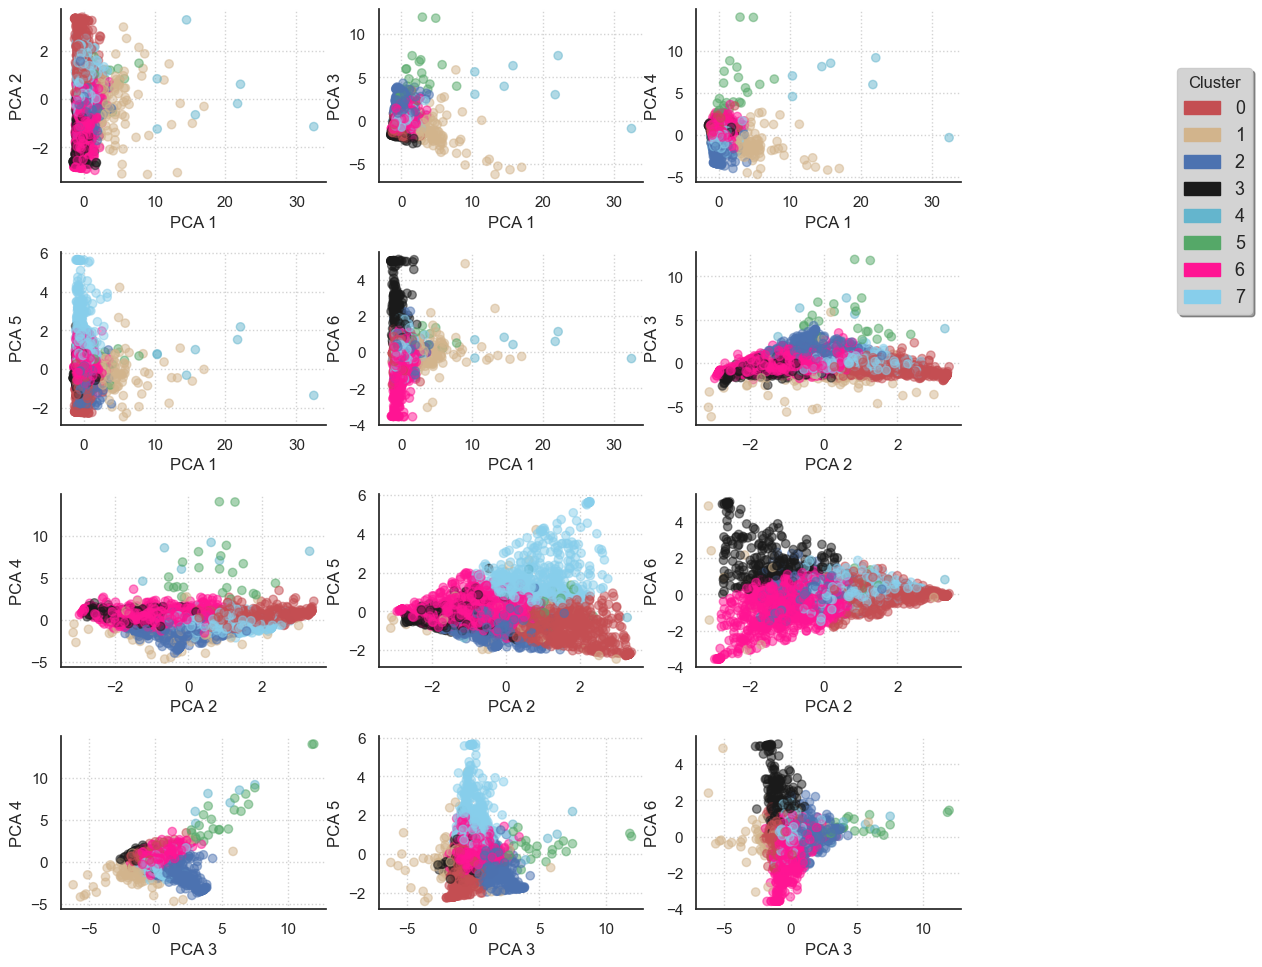

In [165]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.85, top=0.95, wspace=0.2, hspace=0.4)
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

**b/ Score de silhouette intra-cluster**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

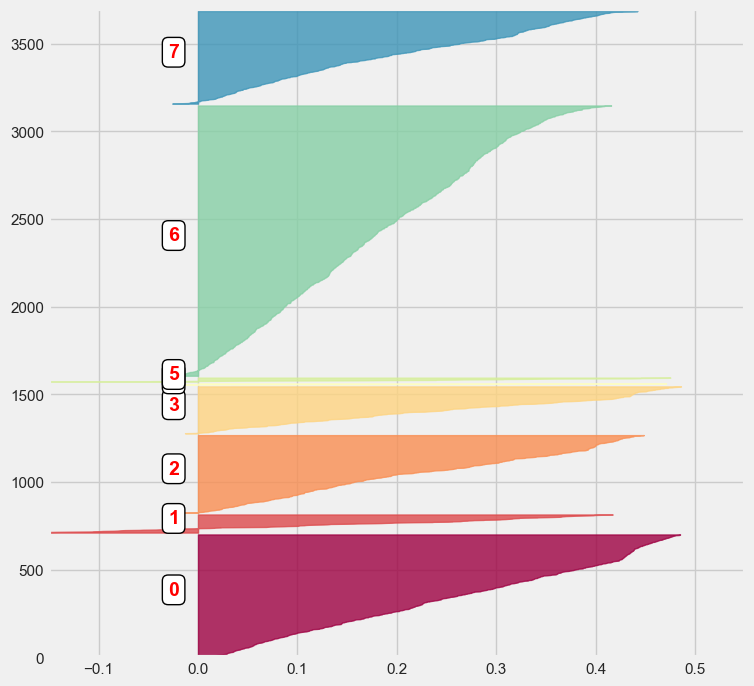

In [166]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

### c/ Customers morphotype

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [167]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable size ):

In [168]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [169]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 35].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,0.0,2.910275,215.893894,407.783227,296.054440,933.848062,56.008024,6.036586,13.023365,12.724725,12.215466,691
1,3.0,2.350746,188.067575,315.857537,242.929864,612.698545,8.261862,54.580476,11.281847,19.238937,6.636878,268
2,2.0,3.148984,211.132079,419.165578,307.032459,1109.511108,12.452209,8.243365,53.458448,16.797995,9.047984,443
3,6.0,3.820480,235.068477,514.517888,355.170870,1415.660603,15.954071,14.353905,18.745828,37.645332,13.306838,1543
4,7.0,2.741021,223.103781,410.735822,304.247787,948.884423,17.926401,7.878240,16.451461,15.865327,41.910088,529
5,1.0,2.201923,1536.667308,2319.749529,1872.259898,4679.818663,23.646786,13.490055,22.866583,24.148818,15.848406,104
6,5.0,55.391304,26.082609,2675.460870,541.091627,28017.319565,26.837292,10.791118,25.858264,20.322059,16.205498,23
7,4.0,26.857143,510.302857,20131.802857,5514.816882,113654.117143,23.354068,7.873243,25.738996,25.445817,17.587876,7


**d / Customers morphology**

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this kernel):

In [170]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:]]
       
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

0.3333333333333333
0.5
2


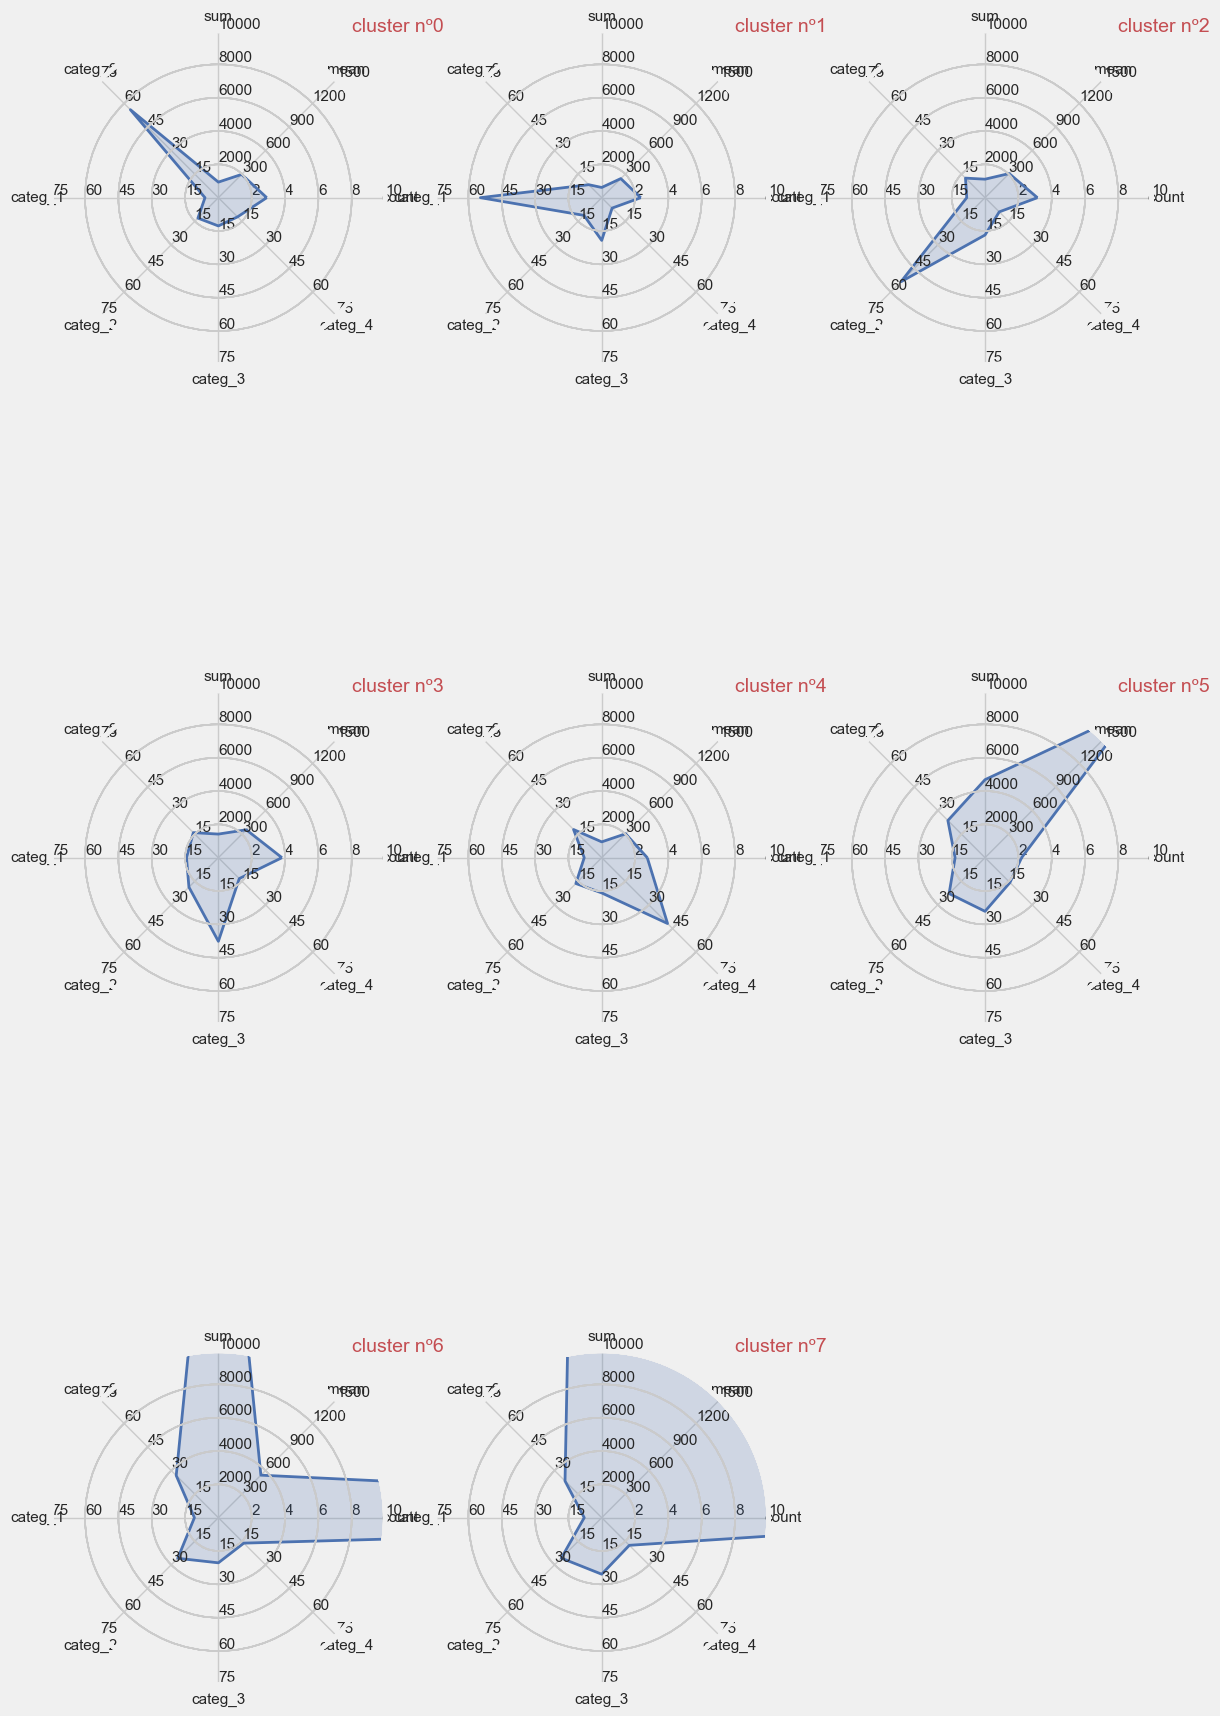

In [171]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)
print(size_x)
print(size_y)
print(i_rows)
for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages ( mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count ).

# 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [172]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [173]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [174]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

## 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the Class_Fit class and then callgrid_search(). When calling this method, I provide as parameters:

the hyperparameters for which I will seek an optimal value<br>
the number of folds to be used for cross-validation

In [175]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [176]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data:

In [177]:
svc.grid_predict(X_test, Y_test)

Precision: 92.24 % 



5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [178]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


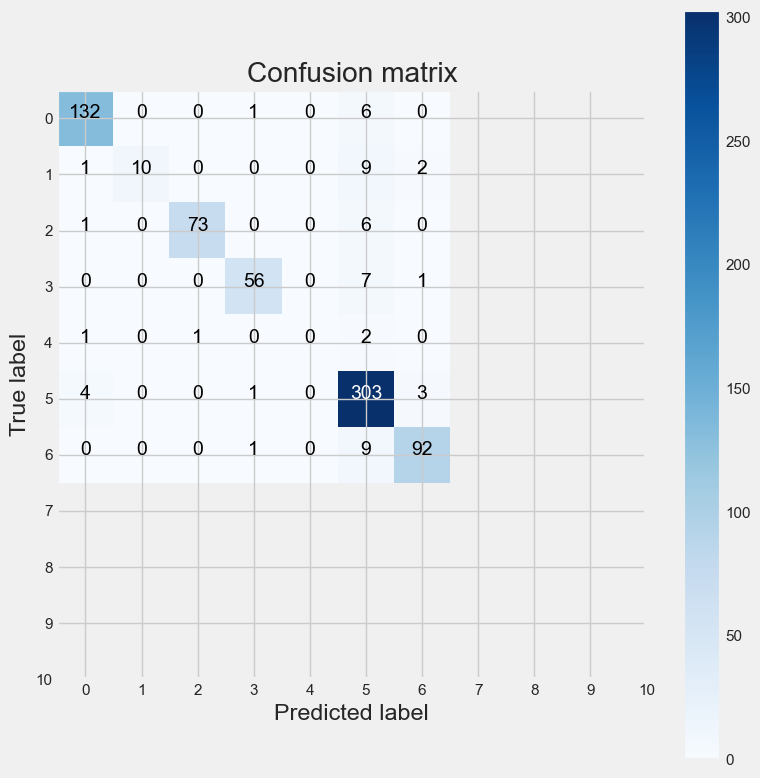

In [179]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-%20self-examples-model-selection-pad-learning-curve-py)

In [180]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

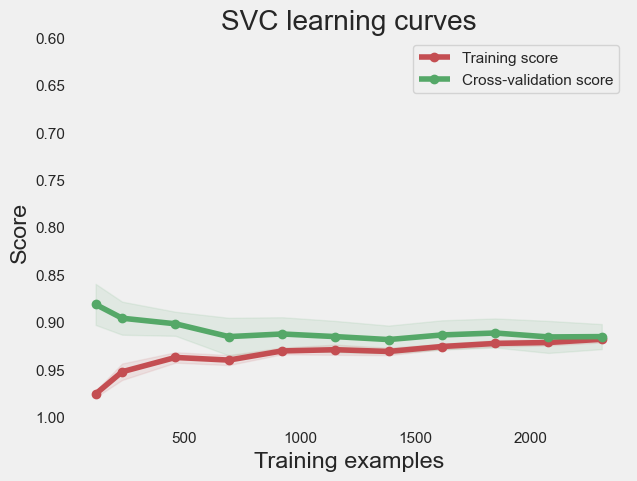

In [181]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

## 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the Class_Fit class, adjust the model on the training data and see how the predictions compare to the real values:

In [183]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 95.15 % 


Then, I plot the learning curve to have a feeling of the quality of the model:

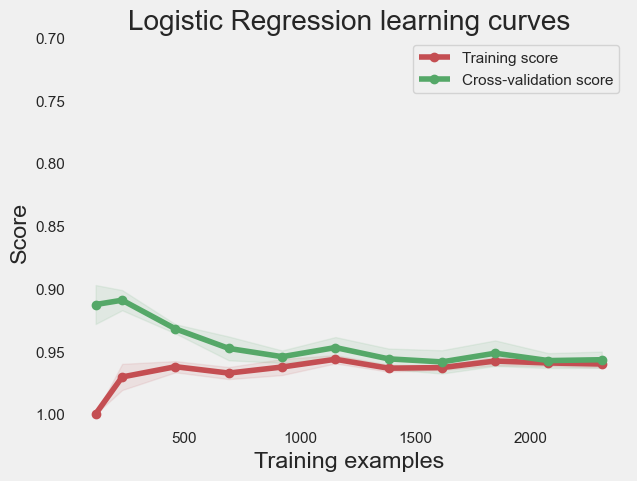

In [184]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.3 k-Nearest Neighbors

In [185]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 88.09 % 


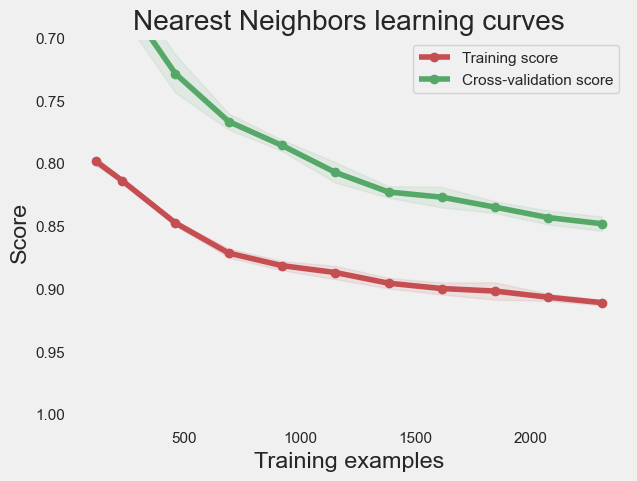

In [186]:

g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.4 Decision Tree

In [187]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 91.97 % 


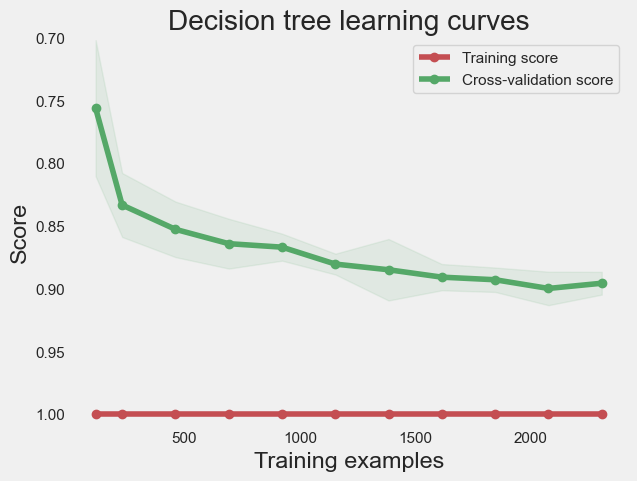

In [188]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train, ylim = [1.01, 0.7], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.5 Random Forest

In [189]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 95.29 % 


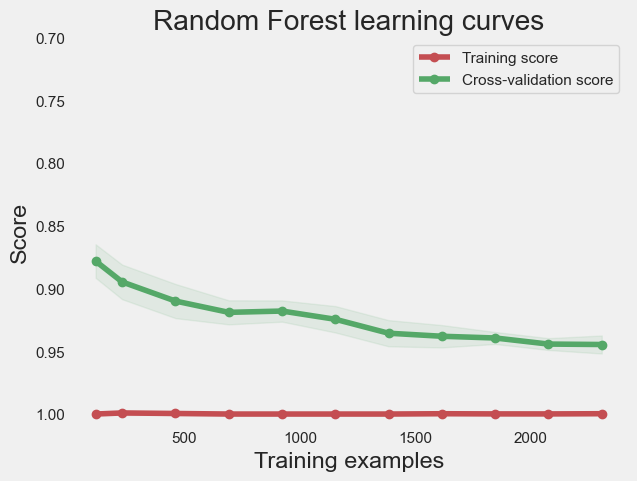

In [190]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.6 AdaBoost Classifier

In [191]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 69.25 % 


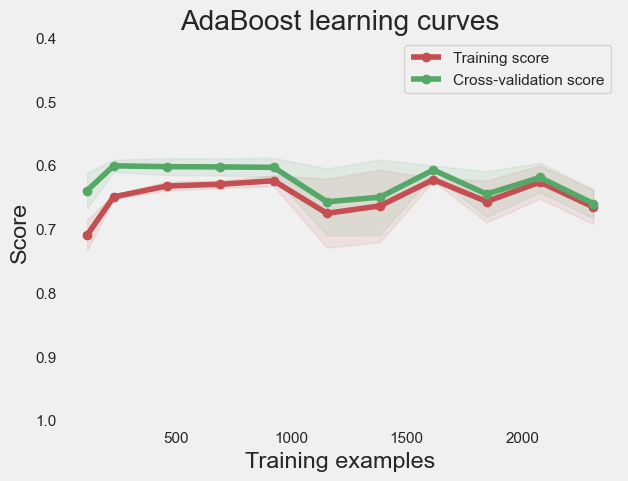

In [192]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.7 Gradient Boosting Classifier

In [193]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 93.49 % 


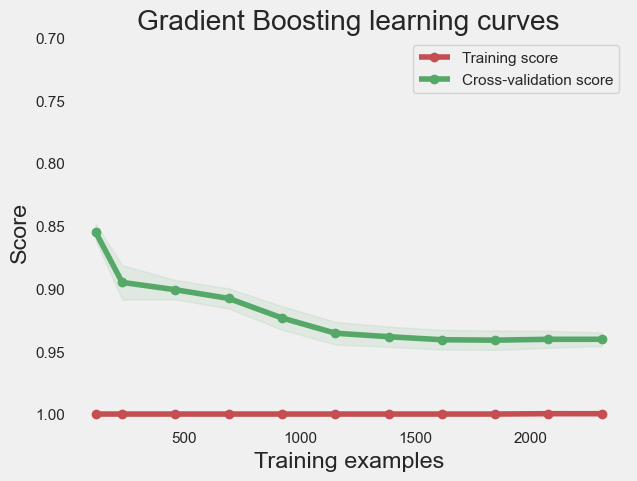

In [194]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.8 Let's vote 

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the VotingClassifier method of the sklearn package. As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

In [195]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [210]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('knn', knn_best)], voting='soft')   

and train it:

In [211]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [212]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 95.15 % 


Note that when defining the votingC classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the Random Forest, the k-Nearest Neighbors and the Gradient Boosting classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

# 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model the last two months of the dataset, that has been stored in the set_test dataframe:

In [213]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set.

In [224]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,2,224.82,1294.32,759.57,1519.14,10.670511,12.696657,32.343299,20.017905,24.271627
1,12349,1,1757.55,1757.55,1757.55,1757.55,46.021450,4.513101,12.245455,26.506216,10.713778
2,12352,1,311.73,311.73,311.73,311.73,42.953838,6.672441,8.735123,34.420813,7.217785
3,12356,1,58.35,58.35,58.35,58.35,100.000000,0.000000,0.000000,0.000000,0.000000
4,12357,1,6207.67,6207.67,6207.67,6207.67,33.399810,5.089832,14.684737,18.475531,28.350089


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [225]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables count , min , max and sum ). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the kmeans method used in section 4. The predict method of this instance calculates the distance of the consumers from the centroids of the 8 client classes and the smallest distance will define the belonging to the different categories:

In [228]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [230]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [232]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 91.22 % 
______________________________ 
Logostic Regression
Precision: 95.96 % 
______________________________ 
k-Nearest Neighbors
Precision: 84.08 % 
______________________________ 
Decision Tree
Precision: 90.67 % 
______________________________ 
Random Forest
Precision: 95.14 % 
______________________________ 
Gradient Boosting
Precision: 94.24 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [233]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 94.79 % 


# 7. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately  ∼
 4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 8 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 8 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:

mean : amount of the basket of the current purchase
categ_N with  N∈[0:4]
 : percentage spent in product category with index  N
 
Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 95% of clients are awarded the right classes. The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.